<a href="https://colab.research.google.com/github/khasirih/SQL-project/blob/main/SQL_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 23s 40ms/step - loss: 2.2538 - val_loss: 0.4134 - learning_rate: 0.0010
Epoch 2/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 23s 46ms/step - loss: 0.2918 - val_loss: 0.1071 - learning_rate: 0.0010
Epoch 3/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step - loss: 0.0720 - val_loss: 0.0475 - learning_rate: 0.0010
Epoch 4/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - loss: 0.0222 - val_loss: 0.0324 - learning_rate: 0.0010
Epoch 5/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 20s 37ms/step - loss: 0.0087 - val_loss: 0.0115 - learning_rate: 0.0010
Epoch 6/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 22s 40ms/step - loss: 0.0055 - val_loss: 0.0043 - learning_rate: 0.0010
Epoch 7/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - loss: 0.0048 - val_loss: 0.0047 - learning_rate: 0.0010
Epoch 8/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - loss: 0.0043 - val_loss: 0.0035 - learning_rate: 0.0010
Epoch 9/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 22s 41ms/step - loss: 0.0039 - val_loss: 0.0063 - learning_rate:

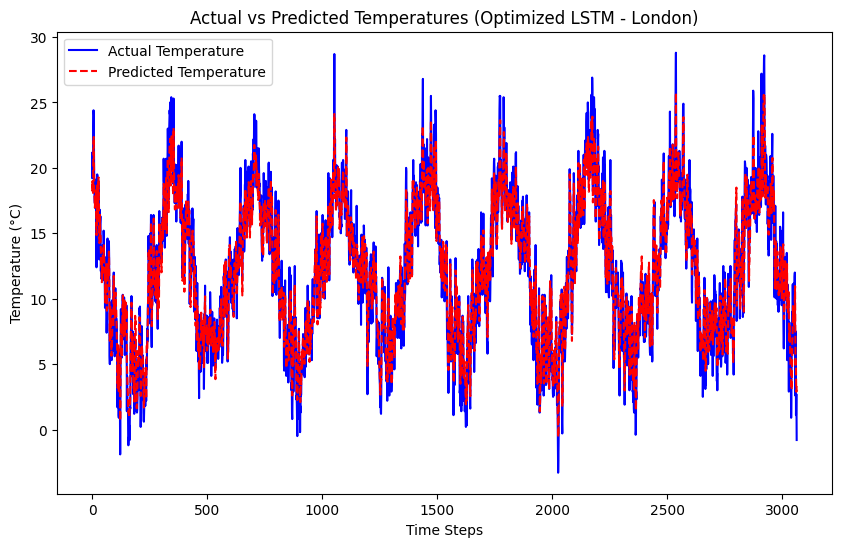

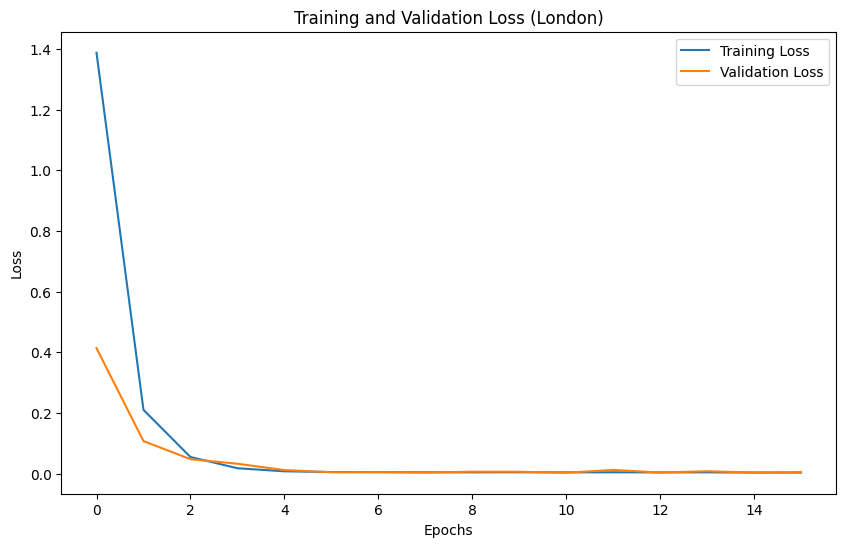

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv("london_weather.csv")

# Prepare date and relevant columns
data['date'] = pd.to_datetime(data['date'])
data = data[['date', 'mean_temp', 'max_temp', 'min_temp', 'cloud_cover', 'sunshine',
             'global_radiation', 'precipitation', 'pressure', 'snow_depth']]

# Replace missing data if necessary
data.replace(-99, np.nan, inplace=True)
data.interpolate(method='linear', inplace=True)
data.bfill(inplace=True)

# Adding additional features
data['Month'] = data['date'].dt.month
data['DayOfYear'] = data['date'].dt.dayofyear
data['Lag_1'] = data['mean_temp'].shift(1)
data['Lag_2'] = data['mean_temp'].shift(2)
data['Rolling_Mean_3'] = data['mean_temp'].rolling(window=3).mean()
data['Rolling_Mean_7'] = data['mean_temp'].rolling(window=7).mean()
data['Sin_Month'] = np.sin(2 * np.pi * data['Month'] / 12)
data['Cos_Month'] = np.cos(2 * np.pi * data['Month'] / 12)
data.dropna(inplace=True)
data.set_index('date', inplace=True)

# Adjusted feature selection to match Excel columns
features = ['max_temp', 'min_temp', 'cloud_cover', 'sunshine', 'global_radiation',
            'precipitation', 'pressure', 'snow_depth', 'Month', 'DayOfYear',
            'Lag_1', 'Lag_2', 'Rolling_Mean_3', 'Rolling_Mean_7', 'Sin_Month', 'Cos_Month']
target = 'mean_temp'

# Normalization
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[features + [target]])

# Function to create sequences
def create_sequences(data, target_idx, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length, :-1])
        y.append(data[i + seq_length, target_idx])
    return np.array(X), np.array(y)

# Sequence length
seq_length = 15
X, y = create_sequences(scaled_data, target_idx=len(features), seq_length=seq_length)
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# LSTM model
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(seq_length, len(features)), kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.3),
    LSTM(64, return_sequences=True, kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.2),
    LSTM(32, return_sequences=False, kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.1),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Add callbacks
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)

# Predictions on test data
y_pred = model.predict(X_test)

# Metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nTest Metrics:")
print(f"MSE: {mse:.3f}")
print(f"MAE: {mae:.3f}")
print(f"R²: {r2:.3f}")

# Rescale values and prediction
y_pred_rescaled = scaler.inverse_transform(
    np.concatenate((np.zeros((len(y_pred), len(features))), y_pred), axis=1)
)[:, -1]
y_test_rescaled = scaler.inverse_transform(
    np.concatenate((np.zeros((len(y_test), len(features))), y_test.reshape(-1, 1)), axis=1)
)[:, -1]

# Compute rescaled metrics
mse_rescaled = mean_squared_error(y_test_rescaled, y_pred_rescaled)
mae_rescaled = mean_absolute_error(y_test_rescaled, y_pred_rescaled)

print(f"\nRescaled Metrics:")
print(f"MSE (Rescaled): {mse_rescaled:.3f}")
print(f"MAE (Rescaled): {mae_rescaled:.3f}")

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label='Actual Temperature', color='blue')
plt.plot(y_pred_rescaled, label='Predicted Temperature', color='red', linestyle='--')
plt.title('Actual vs Predicted Temperatures (Optimized LSTM - London)')
plt.xlabel('Time Steps')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (London)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving weekly_weather.csv to weekly_weather.csv


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.1633 - val_loss: 0.0257
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0560 - val_loss: 0.0541
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0651 - val_loss: 0.0338
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0656 - val_loss: 0.0322
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0642 - val_loss: 0.0341
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0555 - val_loss: 0.0374
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0549 - val_loss: 0.0355
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0654 - val_loss: 0.0332
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0552 - val_loss: 0.0354
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0584 - val_loss: 0.0364
Epoch 11/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0586 - val_loss: 0.0344
Epoch 12/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0532 - val_l

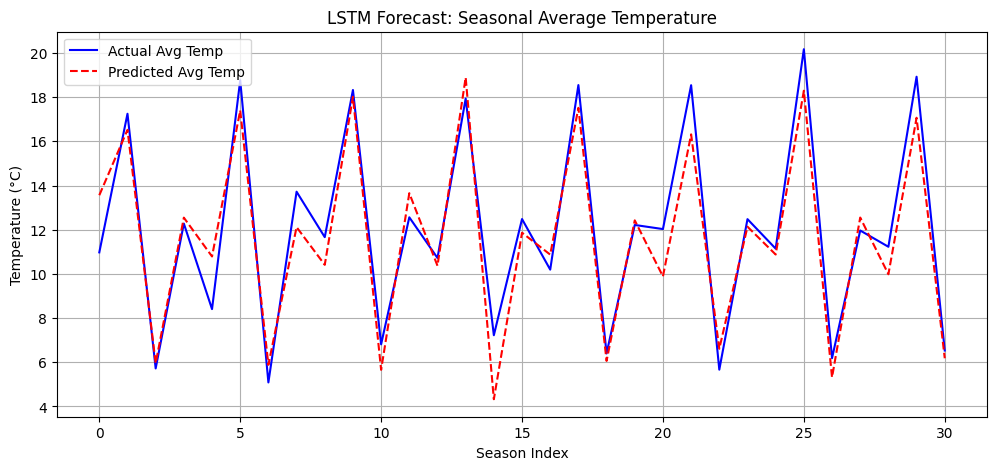

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
# Load seasonal_weather.csv
df = pd.read_csv("seasonal_weather1.csv")

# Remove any nulls or empty rows
df.dropna(inplace=True)

# Map season to numeric values
season_map = {'Winter': 0, 'Spring': 1, 'Summer': 2, 'Autumn': 3}
df['season_num'] = df['season'].map(season_map)

# Features: season number and total precipitation
features = df[['season_num', 'total_precip']].values
target = df['avg_temp'].values.reshape(-1, 1)

# Normalize both features and target
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(features)
y_scaled = scaler_y.fit_transform(target)

# Combine and create sequences
sequence_length = 4  # 4 seasons = 1 year
X_seq, y_seq = [], []

for i in range(len(X_scaled) - sequence_length):
    X_seq.append(X_scaled[i:i+sequence_length])
    y_seq.append(y_scaled[i+sequence_length])

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)
# 80% train, 20% test
split = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]
#Build
model = Sequential()
model.add(LSTM(64, activation='tanh', input_shape=(X_seq.shape[1], X_seq.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

history = model.fit(X_train, y_train, epochs=100, batch_size=8, validation_split=0.1, verbose=1)
#predict and inverse scale
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1))

plt.figure(figsize=(12, 5))
plt.plot(y_actual, label='Actual Avg Temp', color='blue')
plt.plot(y_pred, label='Predicted Avg Temp', color='red', linestyle='--')
plt.title('LSTM Forecast: Seasonal Average Temperature')
plt.xlabel('Season Index')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.show()

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.1699 - val_loss: 0.0593
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0625 - val_loss: 0.0597
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0656 - val_loss: 0.0629
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0475 - val_loss: 0.0538
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0563 - val_loss: 0.0542
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0498 - val_loss: 0.0477
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0502 - val_loss: 0.0486
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0478 - val_loss: 0.0449
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0365 - val_loss: 0.0383
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0369 - val_loss: 0.0331
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0282 - val_loss: 0.0280
Epoch 12/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0324 - val_

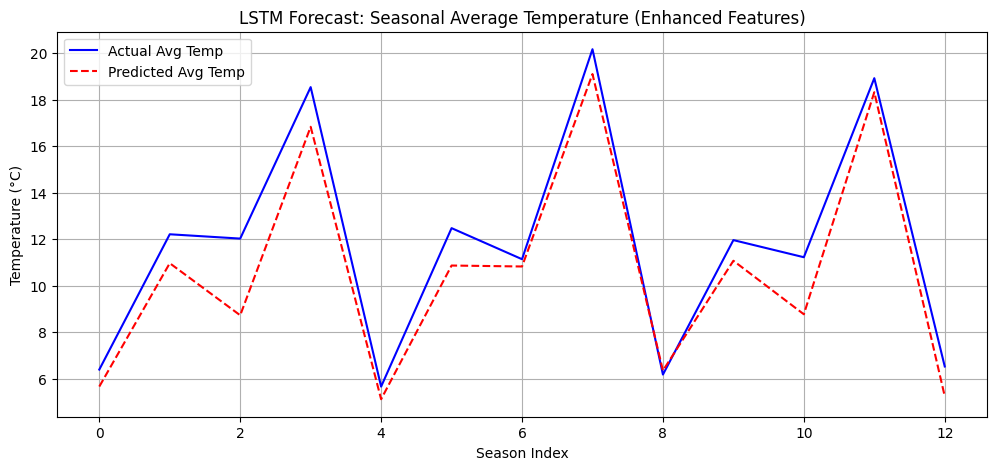

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error
df = pd.read_csv("seasonal_weather1.csv")

# Drop rows with missing values
df.dropna(inplace=True)

# Map season to numeric
season_map = {'Winter': 0, 'Spring': 1, 'Summer': 2, 'Autumn': 3}
df['season_num'] = df['season'].map(season_map)
# Select features
features = [
    'season_num','max_temp', 'min_temp', 'total_precip',
]

target = 'avg_temp'

# Extract arrays
X = df[features].values
y = df[target].values.reshape(-1, 1)

# Normalize
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)
sequence_length = 4  # 4 seasons = 1 year

X_seq, y_seq = [], []
for i in range(len(X_scaled) - sequence_length):
    X_seq.append(X_scaled[i:i+sequence_length])
    y_seq.append(y_scaled[i+sequence_length])

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)
split = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]


model = Sequential()
model.add(LSTM(64, activation='tanh', input_shape=(X_seq.shape[1], X_seq.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

history = model.fit(X_train, y_train, epochs=100, batch_size=8, validation_split=0.1, verbose=1)


y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_actual = scaler_y.inverse_transform(y_test)


mae = mean_absolute_error(y_actual, y_pred)
rmse = np.sqrt(mean_squared_error(y_actual, y_pred))

print(f"MAE: {mae:.2f} °C")
print(f"RMSE: {rmse:.2f} °C")
plt.figure(figsize=(12, 5))
plt.plot(y_actual, label='Actual Avg Temp', color='blue')
plt.plot(y_pred, label='Predicted Avg Temp', color='red', linestyle='--')
plt.title('LSTM Forecast: Seasonal Average Temperature (Enhanced Features)')
plt.xlabel('Season Index')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("seasonal_weather1.csv")
df.dropna(inplace=True)

# Season mapping
df['season_num'] = df['season'].map({'Winter': 0, 'Spring': 1, 'Summer': 2, 'Autumn': 3})

# Features and target
features = ['season_num', 'max_temp', 'min_temp', 'total_precip']
target = 'avg_temp'

X = df[features].values
y = df[target].values.reshape(-1, 1)

# Normalize
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# Create sequences
def create_sequences(X, y, seq_len=4):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len])
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X_scaled, y_scaled)

# Splits to evaluate
splits = [0.6, 0.7, 0.8]
results = []

for ratio in splits:
    split = int(len(X_seq) * ratio)
    X_train, X_test = X_seq[:split], X_seq[split:]
    y_train, y_test = y_seq[:split], y_seq[split:]

    # Define model
    model = Sequential()
    model.add(LSTM(64, activation='tanh', input_shape=(X_seq.shape[1], X_seq.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # Train model
    model.fit(X_train, y_train, epochs=100, batch_size=8, verbose=0)

    # Predict
    y_pred_scaled = model.predict(X_test)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    y_actual = scaler_y.inverse_transform(y_test)

    # Evaluate
    mae = mean_absolute_error(y_actual, y_pred)
    rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
    results.append((f"{int(ratio*100)}/{int((1-ratio)*100)}", mae, rmse))

# Show results
results_df = pd.DataFrame(results, columns=["Train/Test Split", "MAE (°C)", "RMSE (°C)"])
print(results_df)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 760ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
  Train/Test Split  MAE (°C)  RMSE (°C)
0            60/40  1.881523   2.962742
1            70/30  1.862151   2.637222
2            80/19  1.310679   1.883191


MAE: 0.80 °C
RMSE: 0.90 °C


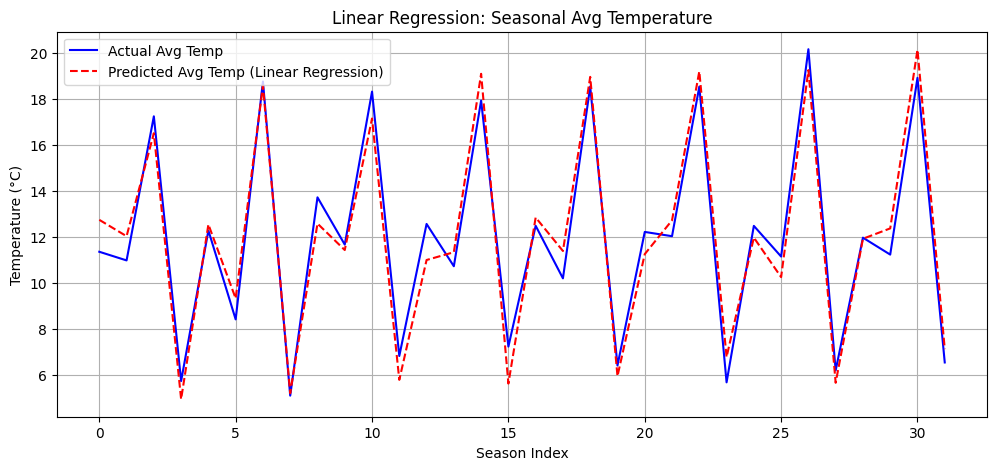

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt

# Load your dataset
df = pd.read_csv("seasonal_weather1.csv")
df.dropna(inplace=True)
df['season_num'] = df['season'].map({'Winter': 0, 'Spring': 1, 'Summer': 2, 'Autumn': 3})
features = ['season_num', 'max_temp', 'min_temp', 'total_precip']
target = 'avg_temp'

X = df[features].values
y = df[target].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False  # keep time order
)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"MAE: {mae:.2f} °C")
print(f"RMSE: {rmse:.2f} °C")
plt.figure(figsize=(12, 5))
plt.plot(y_test, label='Actual Avg Temp', color='blue')
plt.plot(y_pred, label='Predicted Avg Temp (Linear Regression)', color='red', linestyle='--')
plt.title("Linear Regression: Seasonal Avg Temperature")
plt.xlabel("Season Index")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.show()


Linear MAE: 0.69 °C
Linear RMSE: 0.90 °C


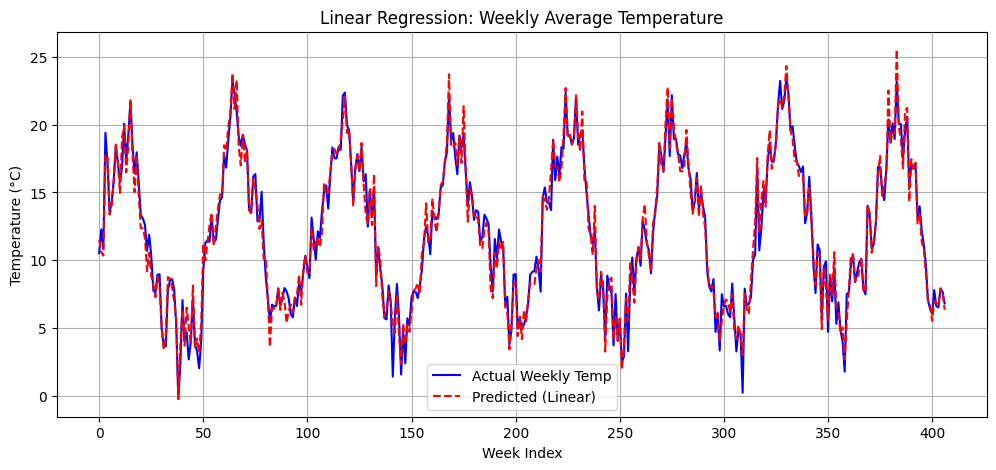

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0686
Epoch 2/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0081
Epoch 3/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0080
Epoch 4/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0072
Epoch 5/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0073
Epoch 6/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0067
Epoch 7/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0069
Epoch 8/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0061
Epoch 9/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0066
Epoch 10/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0061
Epoch 11/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0057
Epoch 12/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0060
Epoch 13/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0058
Epoch 14/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0063
Epoch 15/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step -

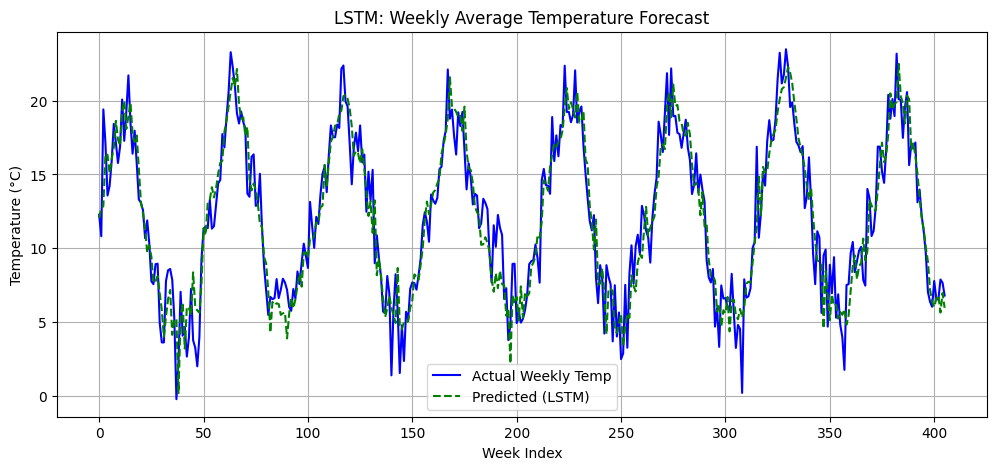

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
df = pd.read_csv("weekly_weather.csv")
df.dropna(inplace=True)
# Features & target
features = ['week_number', 'max_temp', 'min_temp', 'total_precip']
target = 'avg_temp'

X = df[features].values
y = df[target].values

# Split chronologically
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train
model = LinearRegression()
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Linear MAE: {mae:.2f} °C\nLinear RMSE: {rmse:.2f} °C")

# Plot
plt.figure(figsize=(12, 5))
plt.plot(y_test, label='Actual Weekly Temp', color='blue')
plt.plot(y_pred, label='Predicted (Linear)', color='red', linestyle='--')
plt.title("Linear Regression: Weekly Average Temperature")
plt.xlabel("Week Index")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.show()


# Normalize
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# Sequence builder
def create_sequences(X, y, seq_len=4):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len])
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X_scaled, y_scaled)

# Split
split = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]

# Model
model = Sequential()
model.add(LSTM(64, activation='tanh', input_shape=(X_seq.shape[1], X_seq.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=100, batch_size=8, verbose=1)

# Predict
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# Evaluate
mae = mean_absolute_error(y_actual, y_pred)
rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
print(f"LSTM MAE: {mae:.2f} °C\nLSTM RMSE: {rmse:.2f} °C")

# Plot
plt.figure(figsize=(12, 5))
plt.plot(y_actual, label='Actual Weekly Temp', color='blue')
plt.plot(y_pred, label='Predicted (LSTM)', color='green', linestyle='--')
plt.title("LSTM: Weekly Average Temperature Forecast")
plt.xlabel("Week Index")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.show()


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 0.2985 - val_loss: 0.0814
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1062 - val_loss: 0.0333
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0610 - val_loss: 0.0340
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0511 - val_loss: 0.0371
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0472 - val_loss: 0.0340
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0437 - val_loss: 0.0372
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0341 - val_loss: 0.0358
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0320 - val_loss: 0.0376
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0245 - val_loss: 0.0407
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0203 - val_loss: 0.0449
Epoch 11/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0131 - val_loss: 0.0451
Epoch 12/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0

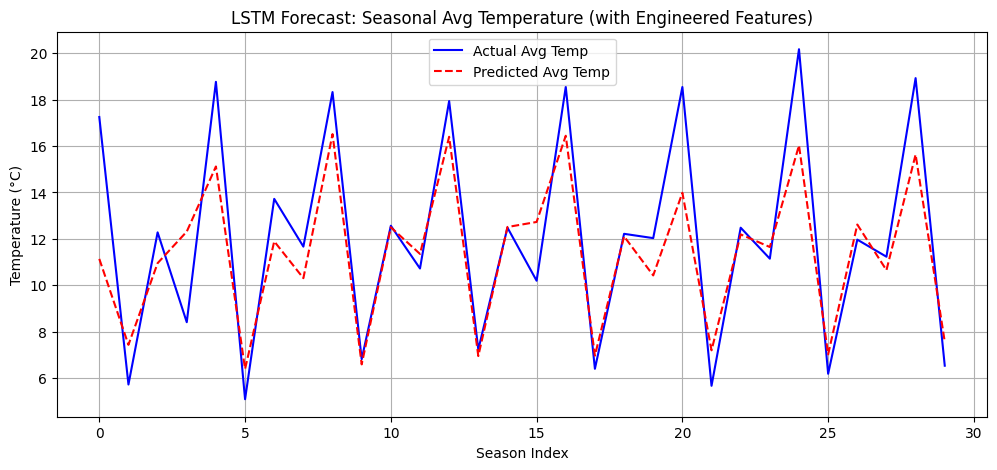

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load and clean
df = pd.read_csv("seasonal_weather1.csv")
df.dropna(inplace=True)

# Encode season
season_map = {'Winter': 0, 'Spring': 1, 'Summer': 2, 'Autumn': 3}
df['season_num'] = df['season'].map(season_map)


# Lags
df['avg_temp_lag_1'] = df['avg_temp'].shift(1)
df['avg_temp_lag_2'] = df['avg_temp'].shift(2)
df['avg_temp_lag_3'] = df['avg_temp'].shift(3)
df['avg_temp_lag_4'] = df['avg_temp'].shift(4)

# Differences and change features
df['avg_temp_diff'] = df['avg_temp_lag_1'] - df['avg_temp_lag_2']
df['avg_precip_lag_1'] = df['total_precip'].shift(1)
df['precip_change'] = df['avg_precip_lag_1'] - df['total_precip'].shift(2)

# Range
df['temp_range'] = df['max_temp'] - df['min_temp']

# Clean nulls after lags
df.dropna(inplace=True)

# Sin/Cos encoding
df['sin_season'] = np.sin(2 * np.pi * df['season_num'] / 4)
df['cos_season'] = np.cos(2 * np.pi * df['season_num'] / 4)

# Updated feature list
features = [
    'season_num', 'year',
    'max_temp', 'min_temp', 'total_precip',
    'sin_season', 'cos_season',
    'avg_temp_lag_1', 'avg_temp_lag_2', 'avg_temp_lag_3', 'avg_temp_lag_4',
    'avg_temp_diff',
    'avg_precip_lag_1', 'precip_change',
    'temp_range'
]

target = 'avg_temp'

# Normalize
X = df[features].values
y = df[target].values.reshape(-1, 1)

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# Create sequences (4-season steps)
seq_length = 4
X_seq, y_seq = [], []
for i in range(len(X_scaled) - seq_length):
    X_seq.append(X_scaled[i:i+seq_length])
    y_seq.append(y_scaled[i+seq_length])

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

# Train-test split
split = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]

# Build LSTM model
model = Sequential()
model.add(LSTM(64, activation='tanh', input_shape=(X_seq.shape[1], X_seq.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train
history = model.fit(X_train, y_train, epochs=100, batch_size=8, validation_split=0.1, verbose=1)

# Predict
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_actual = scaler_y.inverse_transform(y_test)

# Evaluate
mae = mean_absolute_error(y_actual, y_pred)
rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
print(f"MAE: {mae:.2f} °C")
print(f"RMSE: {rmse:.2f} °C")

# Plot predictions
plt.figure(figsize=(12, 5))
plt.plot(y_actual, label='Actual Avg Temp', color='blue')
plt.plot(y_pred, label='Predicted Avg Temp', color='red', linestyle='--')
plt.title('LSTM Forecast: Seasonal Avg Temperature (with Engineered Features)')
plt.xlabel('Season Index')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.show()
